In [128]:
import numpy as np
import dataset
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os
from random import shuffle

In [129]:
HEIGHT = 64
WIDTH = 64
DEPTH = 3

DATA_PATH = '../dataset/stl10_binary/train_X.bin'
LABEL_PATH = '../dataset/stl10_binary/train_y.bin'

In [130]:
images = dataset.read_all_images(DATA_PATH)
labels = dataset.read_labels(LABEL_PATH)

In [131]:
def get_resized_images(images):
    train_X=np.empty((images.shape[0],HEIGHT,WIDTH,3),dtype=np.uint8)
    
    for i in range(images.shape[0]):
        train_X[i] = cv2.resize(images[i],(HEIGHT,WIDTH))
    
    return train_X

In [132]:
train_X = get_resized_images(images)

In [133]:
images= train_X.reshape(5000,64,64,3)


In [134]:
def display_images(images,n):
    size = images.shape[0]
    plt.figure(figsize=(20, 2))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(images[size - i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [135]:
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

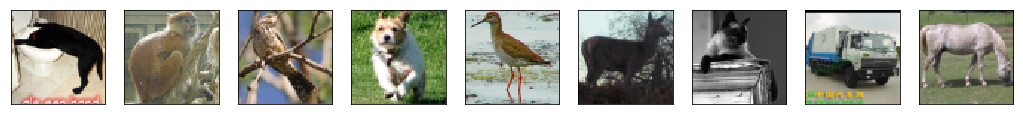

In [136]:
display_images(images,10)

In [137]:
#Noise Functions
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + noise)
     
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [138]:
#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = images.shape[0]/2;
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:],0,1,0.5)
    
    noisy_set = []
    for data in [noise1,noise2]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)
    
    

In [139]:
shuffle(images)
#Getting the noisy image set
noisy_set = add_noise(images)
ground_truth,noisy_images = pair_shuffle(images,noisy_set)

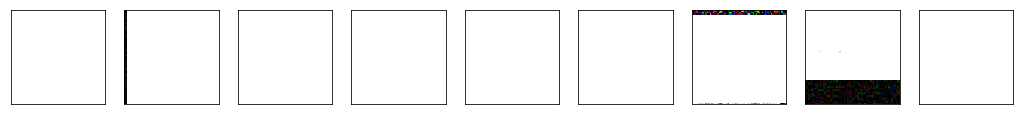

(5000, 64, 64, 3)


In [143]:
display_images(noisy_images,10)
print noisy_images.shape

In [144]:
#Split into training and cross validation
train_size = int(ground_truth.shape[0]*0.8)
x_train = ground_truth[0:train_size]
x_train_noisy = noisy_images[0:train_size]
x_test = ground_truth[train_size:]
x_test_noisy = noisy_images[train_size:]
print x_train_noisy.shape
print x_test_noisy.shape

(4000, 64, 64, 3)
(1000, 64, 64, 3)


In [68]:
from keras.layers import *
from keras.layers.core import Lambda
from keras.models import Model
from keras import regularizers
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


In [82]:
print train.shape

(5000, 64, 64, 3)


In [162]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    gateFactor = Input(tensor = K.variable([gatePercentageFactor]))
    fractionG = Lambda(lambda x: x[0]*x[1])([inputLayer,gateFactor])
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return gateFactor,fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

def get_cnn_architecture(weights_path=None):
    
    input_img = Input(shape=(64,64,3))  # adapt this if using `channels_first` image data format
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    gf1,fg1,c1 = get_gated_connections(0.1,x1)
    
    x = MaxPooling2D((2, 2), padding='same')(fg1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    gf2,fg2,c2 = get_gated_connections(0.2,x2)

    x = MaxPooling2D((2, 2), padding='same')(fg2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    gf3,fg3,c3 = get_gated_connections(0.3,x3)
    
    x = MaxPooling2D((2, 2), padding='same')(x3)
    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    gf4,fg4,c4 = get_gated_connections(0.4,x4)
    
    x = MaxPooling2D((2, 2), padding='same')(x4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x) 
    
    x = UpSampling2D((2, 2))(x5)
    y1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x) 
    jt4 = Add()([y1,c4])
    x = UpSampling2D((2, 2))(jt4)
    
    y2 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) 
    jt3 = Add()([y2,c3])
    x = UpSampling2D((2, 2))(jt3)
    
    y3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x) 
    jt2 = Add()([y3,c2])
    x = UpSampling2D((2, 2))(jt2)
    
    jt1 = Add()([x,c1])
    y4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(jt1)
    y5 = Conv2DTranspose(3, (3, 3), activation='relu', padding='same')(y4) 
    
    layers = y5
    
    model = Model([input_img,gf1,gf2,gf3,gf4],layers)
    model.compile(optimizer='sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
    print model.summary()
    return model

In [163]:
model = get_cnn_architecture()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_77 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_166 (Conv2D)              (None, 64, 64, 64)    1792        input_77[0][0]                   
____________________________________________________________________________________________________
input_78 (InputLayer)            (1,)                  0                                            
____________________________________________________________________________________________________
lambda_79 (Lambda)               (None, 64, 64, 64)    0           conv2d_166[0][0]                 
                                                                   input_78[0][0]          

In [164]:
model.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
 150/4000 [>.............................] - ETA: 407s - loss: nan - acc: 0.4723

KeyboardInterrupt: 

In [106]:
model.predict()

TypeError: predict() takes at least 2 arguments (1 given)